In [1]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import gymnasium as gym
import collections
import random
import matplotlib.pyplot as plt
import SAC_class_setting
import util
import replay_buffer as rb

In [2]:
env_name = 'HalfCheetah-v2'
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_space = env.action_space

/home/nomushroom/anaconda3/envs/rl/lib/python3.9/site-packages/gymnasium/envs/registration.py:523: DeprecationWarning: WARN: The environment HalfCheetah-v2 is out of date. You should consider upgrading to version `v4`.
  logger.deprecation(
/home/nomushroom/anaconda3/envs/rl/lib/python3.9/site-packages/gymnasium/envs/mujoco/mujoco_env.py:185: DeprecationWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.deprecation(


# SAC

In [3]:
actor_lr = 3e-4
critric_lr = 3e-3
alpha_lr = 3e-4
num_episodes = 500
hidden_dim = 128
gamma = 0.99
tau = 0.005
buffer_size = 100000
minimal_size = 1000
batch_size = 64
hidden_layer_num = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
target_entropy = -torch.prod(torch.tensor(env.action_space.shape).to(device))

In [4]:
h_replay_buffer = rb.ReplayBuffer(state_dim, action_dim, buffer_size, device)
half_agent = SAC_class_setting.SACContinuous(h_replay_buffer, state_dim, hidden_dim, action_dim, hidden_layer_num, action_space,
                                    actor_lr, critric_lr, alpha_lr, tau, gamma, device)

return_list = util.train_off_policy_agent(env, half_agent, num_episodes, minimal_size, batch_size)

Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]/home/nomushroom/vsc/SAC_imitationlearning/SAC_class_setting.py:122: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1686122008392/work/torch/csrc/utils/tensor_new.cpp:261.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
Iteration 9: 100%|██████████| 50/50 [05:22<00:00,  6.45s/it, episode=500, return=1433.062]


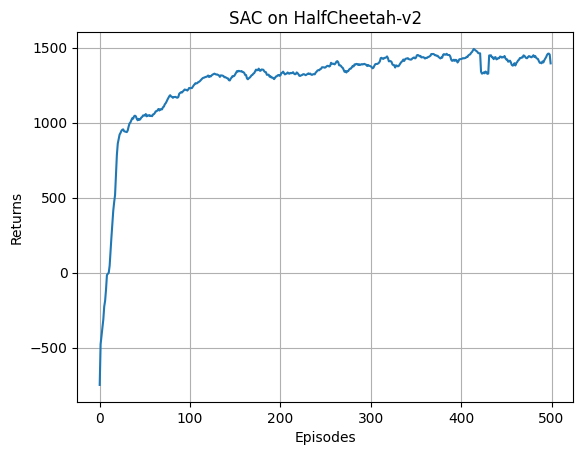

In [5]:
smooth_return = util.smooth_figure(return_list, 9)
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, smooth_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('SAC on {}'.format(env_name))
plt.grid()
plt.show()

In [6]:
np.save('halfCheetah_1000.npy', return_list)

# SAC with prioritized experience replay

In [7]:
h_per_replay_buffer = rb.PrioritizedReplayBuffer(state_dim, action_dim, buffer_size, device)
half_agent_per = SAC_class_setting.SACContinuous(h_per_replay_buffer, state_dim, hidden_dim, action_dim, hidden_layer_num, action_space,
                                    actor_lr, critric_lr, alpha_lr, tau, gamma, device)

return_list_per = util.train_off_policy_agent(env, half_agent_per, num_episodes, minimal_size, batch_size)

Iteration 9: 100%|██████████| 50/50 [06:48<00:00,  8.16s/it, episode=500, return=4434.442]


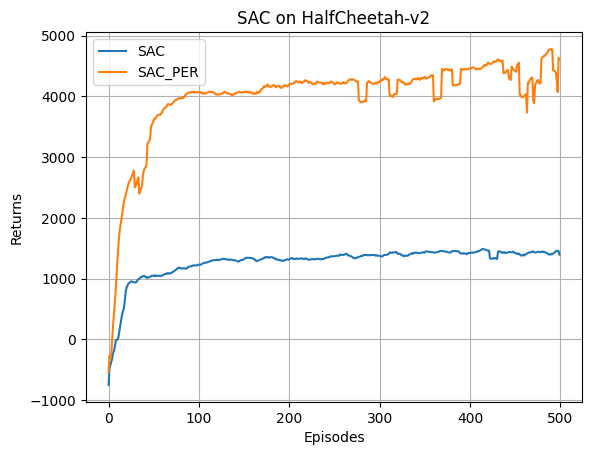

In [8]:
smooth_return = util.smooth_figure(return_list, 9)
smooth_return_per = util.smooth_figure(return_list_per, 9)
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, smooth_return)
plt.plot(episodes_list, smooth_return_per)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('SAC on {}'.format(env_name))
plt.legend(['SAC', 'SAC_PER'])
plt.grid()
plt.show()

In [9]:
np.save('halfCheetah_per_1000.npy', return_list_per)